In [1]:
import sys
import os 
sys.path.append(os.path.dirname(os.getcwd()) + "/src/")

import numpy as np
import torch
import torch.nn as nn
import omegaconf

from eval.utils import encode_features
from model.model import Model
from model.config import ModelConfig
from dataloader.ssl_dataloader import get_dataset
from dataloader.transform import get_weak_augmentation
from matplotlib import pyplot as plt
import copy
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

## Boilerplate needed for notebooks

In [2]:
# ckpt_path = "../results/working_models/simclr_cifar10.pt"
# cfg_path = "../results/working_models/cfg_simclr_cifar10.yaml"

# pos pair, to 1e0, ntx 1e-1
ckpt_path = "../results/prioraug_vi100_dict64_z0-weak_learn-shift_prior-grad_shift1e-3_warmup2000_ntx1e-1_04-06-2023_13-47-02/checkpoints/checkpoint_epoch800.pt"
cfg_path = "../results/prioraug_vi100_dict64_z0-weak_learn-shift_prior-grad_shift1e-3_warmup2000_ntx1e-1_04-06-2023_13-47-02/.hydra/config.yaml"

# nn queue, to 1e0, ntx 1e-1, lie 1e-1
# ckpt_path = "../results/prioraug_vi100-nn-queue_dict64_prior-grad_shift1e-3_ntx1e-1_lie1e-1_l0.005_prior-warmup_04-08-2023_14-29-35/checkpoints/checkpoint_epoch999.pt"
# cfg_path = "../results/prioraug_vi100-nn-queue_dict64_prior-grad_shift1e-3_ntx1e-1_lie1e-1_l0.005_prior-warmup_04-08-2023_14-29-35/.hydra/config.yaml"

# nn loaded, to 1e0, ntx 1e-1, lie 1e-1
# ckpt_path = "../results/prioraug_vi100-nn_dict64_prior-grad_shift1e-3_ntx1e-1_lie1e-1_l0.005_prior-warmup_04-08-2023_11-52-26/checkpoints/checkpoint_epoch999.pt"
# cfg_path = "../results/prioraug_vi100-nn_dict64_prior-grad_shift1e-3_ntx1e-1_lie1e-1_l0.005_prior-warmup_04-08-2023_11-52-26/.hydra/config.yaml"

device_idx = [0]
# Set the default device
default_device = torch.device("cuda:0")
# Load config
cfg = omegaconf.OmegaConf.load(cfg_path)
cfg.model_cfg.backbone_cfg.load_backbone = None

# CUSTOM CONFIG FOR THIS RUN #

# Load model
default_model_cfg = ModelConfig()
model = Model.initialize_model(cfg.model_cfg, cfg.dataloader_cfg.dataset_cfg.dataset_name, device_idx)
state_dict = torch.load(ckpt_path, map_location=default_device)
model.load_state_dict(state_dict['model_state'], strict=False)
# Manually override directory for dataloaders
cfg.dataloader_cfg.dataset_cfg.dataset_dir = "../datasets"
cfg.dataloader_cfg.train_batch_size = 500
# Load dataloaders
dataset = get_dataset(cfg.dataloader_cfg)
train_dataloader = dataset.eval_dataloader
test_dataloader = dataset.val_dataloader
# Get encoding of entire dataset
train_eval_input = encode_features(model, train_dataloader, default_device)
test_eval_input = encode_features(model, test_dataloader, default_device)

# Load transport operators
backbone = model.backbone.backbone_network
transop, coeff_enc = (None, None)
if model.contrastive_header.transop_header is not None:
    transop = model.contrastive_header.transop_header.transop
    coeff_enc = model.contrastive_header.transop_header.coefficient_encoder

# Eval values
x, z, y = train_eval_input.x, train_eval_input.feature_list, train_eval_input.labels
x_test, z_test, y_test = test_eval_input.x, test_eval_input.feature_list, test_eval_input.labels

Using cache found in /storage/home/hcoda1/0/kfallah3/.cache/torch/hub/pytorch_vision_v0.10.0


Files already downloaded and verified
Files already downloaded and verified


In [3]:
unshuffle_dataloder = torch.utils.data.DataLoader(
    dataset=train_dataloader.dataset,
    batch_size=train_dataloader.batch_size,
    shuffle=False,
    num_workers=32,
    pin_memory=True,
    drop_last=False,
)
train_eval_input = encode_features(model, unshuffle_dataloder, default_device)
x, z, y = train_eval_input.x, train_eval_input.feature_list, train_eval_input.labels

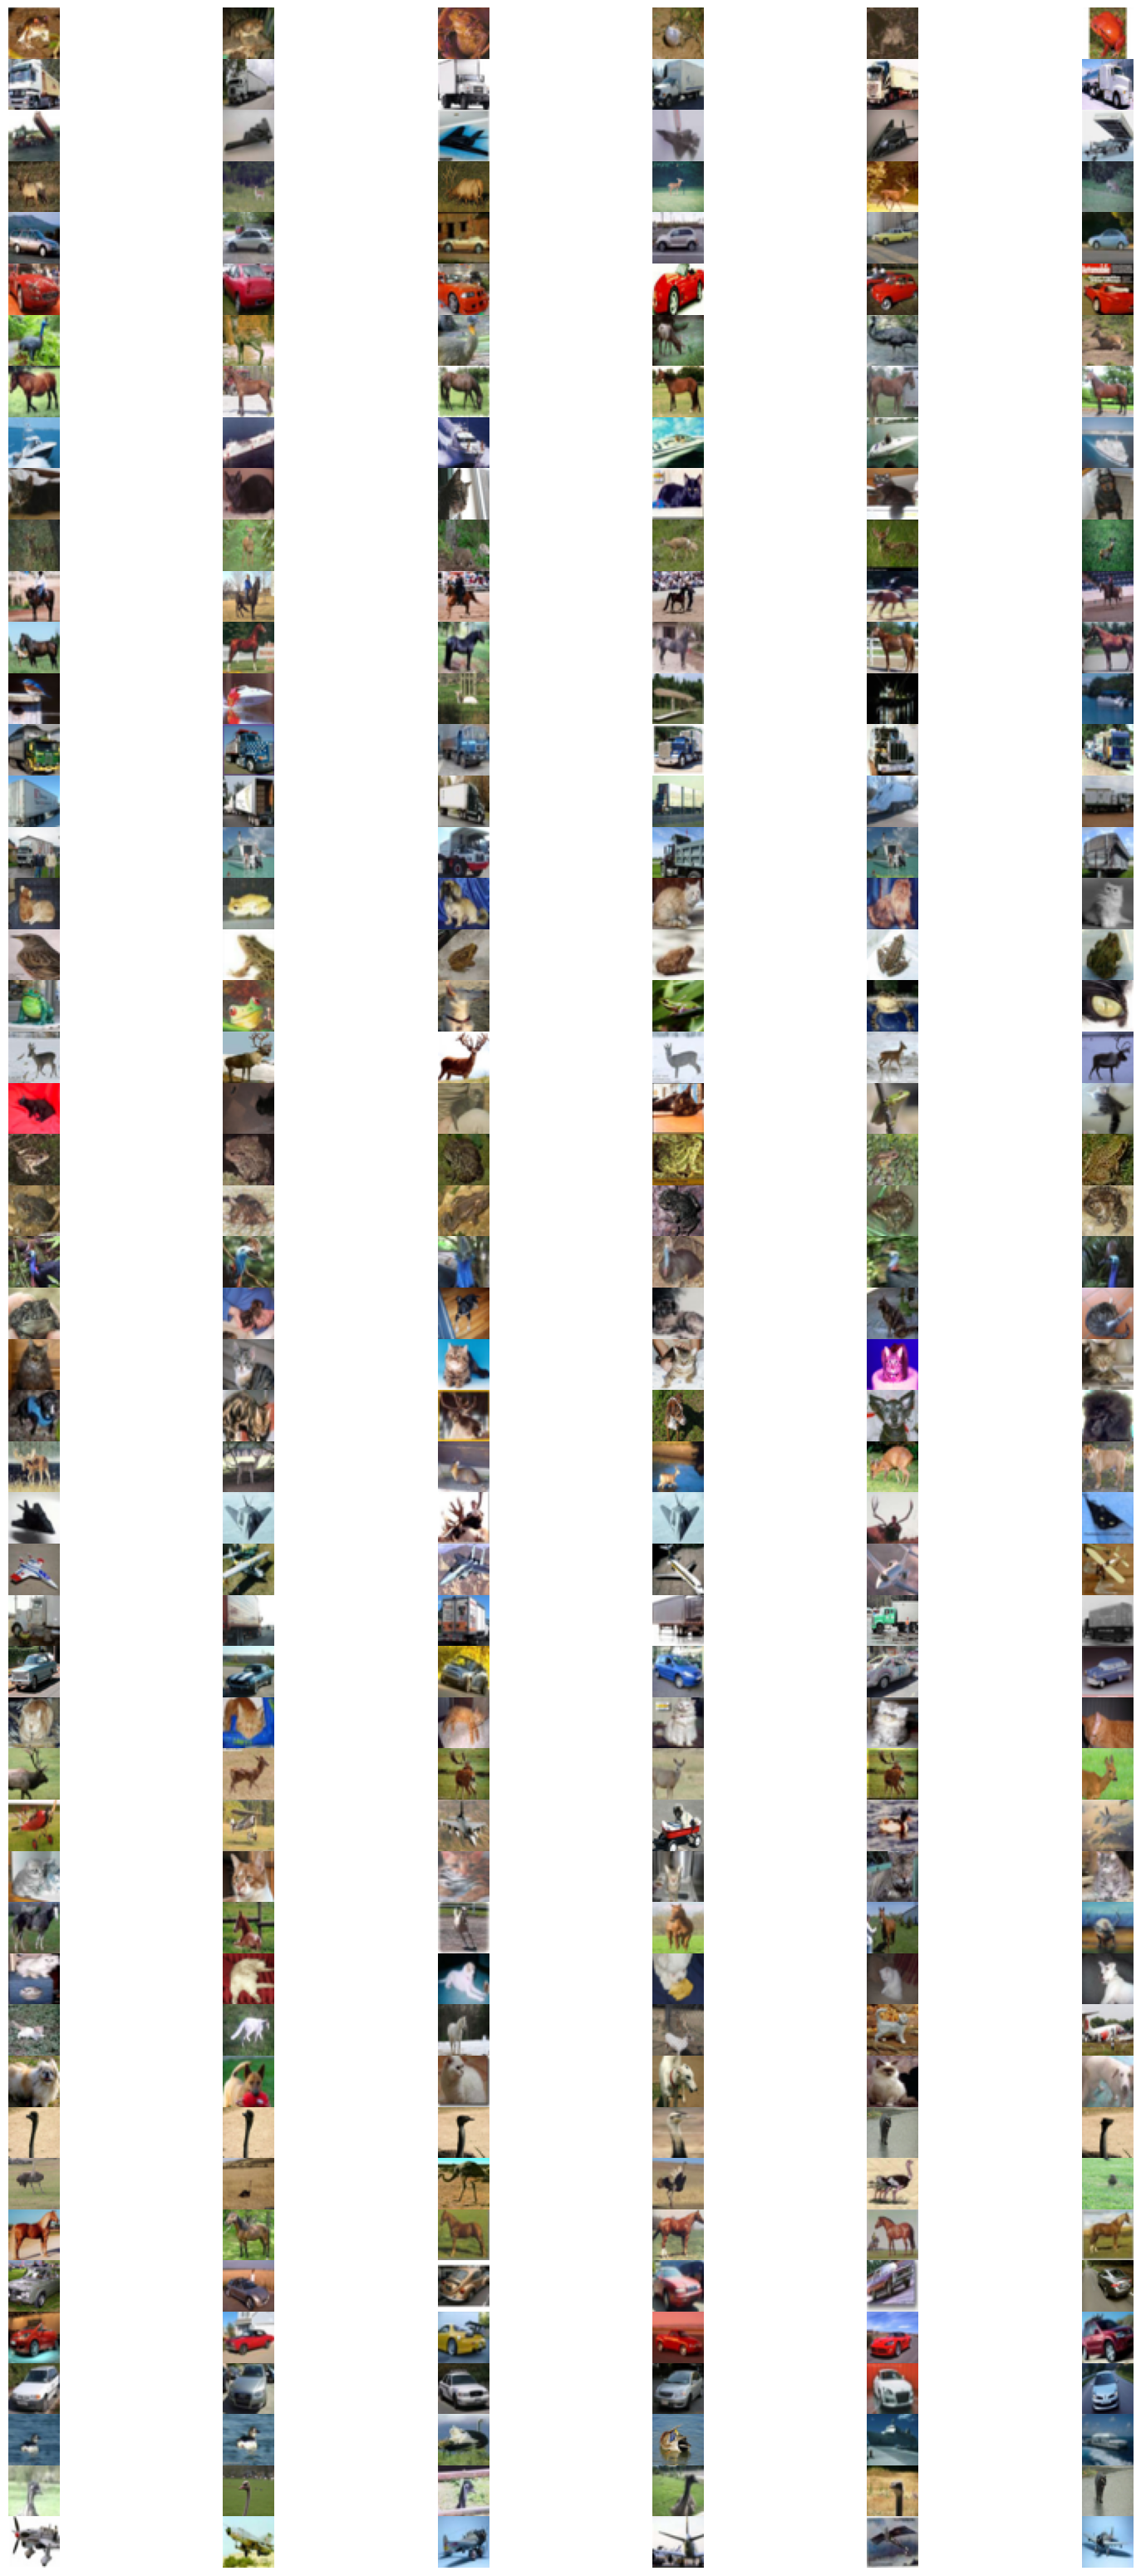

In [4]:
from sklearn.metrics import pairwise_distances_chunked
nn_map = torch.zeros((50000, 5))

pw_dist = pairwise_distances_chunked(z, z)

idx = 0
for i, dist_chunk in enumerate(pw_dist):
    nn_map[idx:idx+len(dist_chunk)] = torch.argsort(torch.tensor(dist_chunk), dim=-1)[:, 1:6]
    idx += len(dist_chunk)

fig, ax = plt.subplots(nrows=50, ncols=6, figsize=(20, 40))
x_im = torch.tensor(train_dataloader.dataset.data)

for k in range(50):
    ax[k, 0].imshow(x_im[k])
    for j in range(5):
        ax[k,j+1].imshow(x_im[int(nn_map[k, j])])
[axi.set_axis_off() for axi in ax.ravel()]
plt.subplots_adjust(wspace=0.0, hspace=0.0)

In [5]:
from sklearn.metrics import pairwise_distances

z_use = z[0].to(default_device)
c_list = []
for i in range(5):
    c = coeff_enc.prior_sample(z_use.unsqueeze(0).detach()).squeeze(0)
    c_list.append(c)
c_list = torch.stack(c_list)
A = torch.einsum("bm,smuv->bsuv", c_list, transop.psi)
T = torch.matrix_exp(A)
z_aug = (T @ z_use.view(1, transop.psi.shape[0], -1, 1)).reshape(len(c_list), -1)
print((z_use**2).sum(dim=-1))
print((z_aug**2).sum(dim=-1))
print(((z_aug - z_use.unsqueeze(0))**2).sum(dim=-1))

tensor(4.0757, device='cuda:0')
tensor([2.9253, 2.3888, 3.0895, 2.2691, 2.4813], device='cuda:0',
       grad_fn=<SumBackward1>)
tensor([0.2263, 0.3722, 0.1568, 0.3368, 0.4742], device='cuda:0',
       grad_fn=<SumBackward1>)


In [8]:
aug_idx = 0
num_im = 10
num_augs = 8
aug_list = torch.zeros((num_im, num_augs, 512))

for i in range(num_im):
    for j in range(num_augs):
        z0 = z[aug_idx+i].to(default_device)
        c = coeff_enc.prior_sample(z0.unsqueeze(0).detach()).squeeze(0)*2
        A = torch.einsum("m,smuv->suv", c, transop.psi)
        T = torch.matrix_exp(A)
        zu_aug = (T @ z0.reshape(transop.psi.shape[0], -1, 1)).reshape(*z0.shape)
        aug_list[i,j] = zu_aug.detach().cpu()

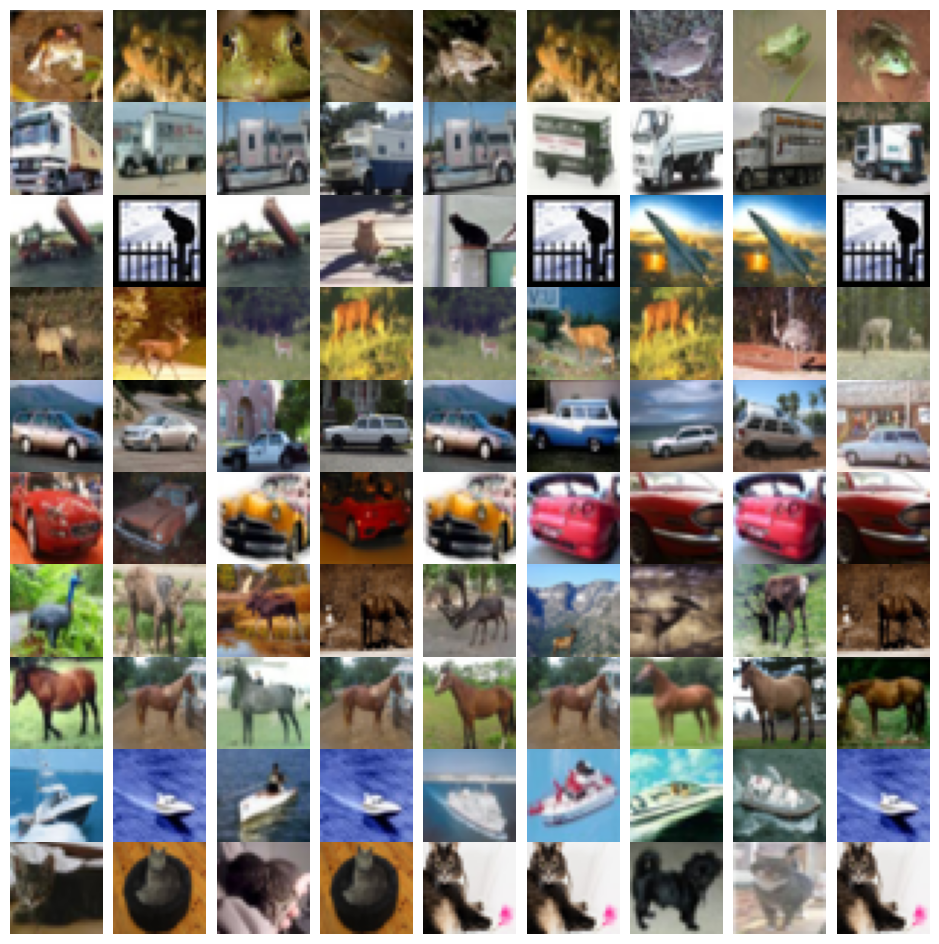

In [9]:
from sklearn.metrics import pairwise_distances

x_im = torch.tensor(train_dataloader.dataset.data)
fig, ax = plt.subplots(nrows=num_im, ncols=num_augs+1, figsize=(12, 12))

for k in range(num_im):
    pw_dist = pairwise_distances(z, aug_list[k])
    nn_idx = torch.argmin(torch.tensor(pw_dist), dim=0)
    ax[k, 0].imshow(x_im[aug_idx + k])
    for i in range(num_augs):
        ax[k,i+1].imshow(x_im[nn_idx[i]])
[axi.set_axis_off() for axi in ax.ravel()]
plt.subplots_adjust(wspace=0.0, hspace=0.0)
print()

In [ ]:
class SSLDataLoader(object):
    def __init__(self, labeled_dset, unlabeled_dset, bsl, bsu, num_workers):
        sampler_lab = InfBatchSampler(labeled_dset, bsl)
        sampler_unlab = InfBatchSampler(unlabeled_dset, bsu)

        wl = max(int(num_workers * bsl / (bsl + bsu)), min(1, num_workers))
        wu = num_workers - wl
        self.labeled_dset = torch.utils.data.DataLoader(labeled_dset, batch_sampler=sampler_lab, num_workers=wl)
        self.unlabeled_dset = torch.utils.data.DataLoader(unlabeled_dset, batch_sampler=sampler_unlab, num_workers=wu)

        self.labeled_iter = iter(self.labeled_dset)
        self.unlabeled_iter = iter(self.unlabeled_dset)

    def __iter__(self):
        return self

    def __next__(self):
        try:
            data_l = next(self.labeled_iter)
        except StopIteration:
            self.labeled_iter = iter(self.labeled_dset)
            data_l = next(self.labeled_iter)

        try:
            data_u = next(self.unlabeled_iter)
        except StopIteration:
            self.unlabeled_iter = iter(self.unlabeled_dset)
            data_u = next(self.unlabeled_iter)

        return data_l, data_u


class InfBatchSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size):
        super(InfBatchSampler, self).__init__(data_source)

        self.N = len(data_source)
        self.batch_size = batch_size if batch_size < self.N else self.N
        self.L = self.N // self.batch_size

    def __iter__(self):
        while True:
            idx = np.random.permutation(self.N)
            for i in range(self.L):
                yield idx[i * self.batch_size : (i + 1) * self.batch_size]

    def __len__(self):
        return sys.maxsize

In [3]:
def get_dataloader(labels_per_class, num_classes=10, seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

    label_dataset = copy.deepcopy(train_dataloader.dataset)
    unlabel_dataset = copy.deepcopy(train_dataloader.dataset)
    transform = get_weak_augmentation(cfg.dataloader_cfg.ssl_aug_cfg, 32)

    data = label_dataset.data
    targets = label_dataset.targets
    label_idx = []
    for i in range(num_classes):
        idx = np.where(np.array(targets) == i)[0]
        subset_idx = np.random.choice(idx, labels_per_class, replace=False)
        label_idx.append(subset_idx)
    label_idx = np.concatenate(label_idx)
    label_dataset.data = np.array(data)[label_idx]
    label_dataset.targets =  np.array(targets)[label_idx]
    label_dataset.transform = transform

    unlabel_idx = np.arange(len(data))[~np.in1d(np.arange(len(data)), label_idx)]
    unlabel_dataset.data = np.array(data)[unlabel_idx]
    unlabel_dataset.targets =  np.array(targets)[unlabel_idx]
    unlabel_dataset.transform = transform

    return SSLDataLoader(label_dataset, unlabel_dataset, 32, 224, 32)

def get_feature_split(labels_per_class, features, labels, num_classes=10, seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

    labeled_idx = []
    for i in range(num_classes):
        idx = torch.where(labels == i)[0]
        subset_idx = np.random.choice(idx.detach().cpu().numpy(), labels_per_class, replace=False)
        labeled_idx.append(subset_idx)
    labeled_idx = np.concatenate(labeled_idx)
    unlabel_idx = np.arange(len(features))[~np.in1d(np.arange(len(features)), labeled_idx)]

    zl, yl = features[labeled_idx], labels[labeled_idx]
    zul, yul = features[unlabel_idx], labels[unlabel_idx]

    return (zl, yl), (zul, yul)



In [5]:
from lightly.models.utils import deactivate_requires_grad

labels_per_class = 5
num_classes = 10
num_iters = 10000
finetune = False

for exp_iter in range(3):
    print(f"Exp iter {exp_iter+1}")
    ssl_dataloader = get_dataloader(labels_per_class, num_classes, exp_iter)

    clf = nn.Linear(512, 10).to(default_device)
    backbone_train = copy.deepcopy(backbone)
    if finetune: 
        optimizer = torch.optim.SGD(list(clf.parameters()) + list(backbone_train.parameters()), lr=0.05, weight_decay=1.0e-5, nesterov=True, momentum=0.9)
    else:
        optimizer = torch.optim.SGD(clf.parameters(), lr=0.05, weight_decay=1.0e-5, nesterov=True, momentum=0.9)
        deactivate_requires_grad(backbone_train)
    criterion = torch.nn.functional.cross_entropy
    curr_iter = 0

    while curr_iter < num_iters:
        for _, data in enumerate(ssl_dataloader):
            if curr_iter >= num_iters:
                break
            if finetune: 
                backbone_train.train()
            else:
                backbone_train.eval()

            (xl, yl), (xu, _) = data
            xl, xu, yl = xl.to(default_device), xu.to(default_device), yl.to(default_device)

            x = torch.cat([xl, xu])
            # random perm to prevent cheating with batch stats
            perm = torch.randperm(len(x))
            perm_inv = torch.argsort(perm)

            z = backbone_train(x[perm])[perm_inv]
            zl, zu = z[:len(xl)], z[len(xl):]

            # # TO AUG
            if transop is None:
                zu_aug = zu.clone()
            else:
                c = coeff_enc.prior_sample(zu.detach())
                A = torch.einsum("bm,smuv->bsuv", c, transop.psi)
                T = torch.matrix_exp(A)
                zu_aug = (T @ zu.reshape(len(zu), transop.psi.shape[0], -1, 1)).reshape(*zu.shape)

            y_pred = clf(zl)
            loss = criterion(y_pred, yl)

            # Consistency Regularization 
            xu_aug_logits = clf(zu_aug)           
            xu_prob = torch.softmax(clf(zu).detach(), dim=-1)
            wu, yu = torch.max(xu_prob, dim=1)
            wu = (wu > 0.95).detach()
            loss_con = criterion(xu_aug_logits, yu, reduction="none")
            loss_con = torch.sum(loss_con[wu]) / len(wu)

            optimizer.zero_grad()
            (loss + loss_con).backward()
            optimizer.step()
        
            if curr_iter % 1000 == 0 or (curr_iter+1) == num_iters:
                z_list = []
                backbone_train.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for idx, batch in enumerate(test_dataloader):
                        x, y = batch
                        x, y = x.to(default_device), y.to(default_device)
                        z = backbone_train(x)

                        y_pred = clf(z)
                        y_pred = y_pred.topk(1, 1, largest=True, sorted=True).indices
                        total += len(y_pred)
                        correct += (y_pred[:, 0] == y).sum().item()
                        z_list.append(z.detach().cpu().numpy())
                z_list = np.concatenate(z_list)
                print(f"Iter {curr_iter} -- acc: {(correct / total)*100:.2f}%, selected: {(sum(wu)/len(xu))*100:.2f}%, z norm: {(z**2).sum(axis=-1).mean():.2f}")
            curr_iter += 1
    print()
    print()

Exp iter 1


NameError: name 'SSLDataLoader' is not defined

In [7]:
from lightly.models.utils import deactivate_requires_grad

labels_per_class = 5
num_classes = 10
num_iters = 10000

for exp_iter in range(3):
    print(f"Exp iter {exp_iter+1}")
    (train_zl, train_yl), (train_zul, train_yul) = get_feature_split(labels_per_class, z, y, seed=exp_iter)

    #clf = nn.Linear(512, 10).to(default_device)
    clf = nn.Sequential(
        nn.Linear(512, 2048),
        nn.LeakyReLU(),
        nn.Linear(2048, 10)
    )
    backbone_train = copy.deepcopy(backbone)
    optimizer = torch.optim.Adam(clf.parameters(), lr=0.001, weight_decay=1.0e-5)
    deactivate_requires_grad(backbone_train)
    backbone_train.eval()
    criterion = torch.nn.functional.cross_entropy
    curr_iter = 0

    while curr_iter < num_iters:
        label_idx, unlabel_idx = torch.randperm(len(train_zl))[:32], torch.randperm(len(train_zul))[:224]
        zl, yl = train_zl[label_idx].to(default_device), train_yl[label_idx].to(default_device)
        zu = train_zul[unlabel_idx].to(default_device)

        # # TO AUG
        if transop is None:
            zu_aug = zu.clone()
        else:
            c = coeff_enc.prior_sample(zu.detach())
            A = torch.einsum("bm,smuv->bsuv", c, transop.psi)
            T = torch.matrix_exp(A)
            zu_aug = (T @ zu.reshape(len(zu), transop.psi.shape[0], -1, 1)).reshape(*zu.shape)

        y_pred = clf(zl)
        loss = criterion(y_pred, yl)

        # Consistency Regularization 
        xu_aug_logits = clf(zu_aug)           
        xu_prob = torch.softmax(clf(zu).detach(), dim=-1)
        wu, yu = torch.max(xu_prob, dim=1)
        wu = (wu > 0.95).detach()
        loss_con = criterion(xu_aug_logits, yu, reduction="none")
        loss_con = torch.sum(loss_con[wu]) / len(wu)

        optimizer.zero_grad()
        (loss + loss_con).backward()
        optimizer.step()
    
        if curr_iter % 1000 == 0 or (curr_iter+1) == num_iters:
            z_list = []
            backbone_train.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for idx, batch in enumerate(test_dataloader):
                    x, y = batch
                    x, y = x.to(default_device), y.to(default_device)
                    z = backbone_train(x)

                    y_pred = clf(z)
                    y_pred = y_pred.topk(1, 1, largest=True, sorted=True).indices
                    total += len(y_pred)
                    correct += (y_pred[:, 0] == y).sum().item()
                    z_list.append(z.detach().cpu().numpy())
            z_list = np.concatenate(z_list)
            print(f"Iter {curr_iter} -- acc: {(correct / total)*100:.2f}%, selected: {(sum(wu)/len(zu))*100:.2f}%, z norm: {(z**2).sum(axis=-1).mean():.2f}")
        curr_iter += 1
    print()
    print()

Exp iter 1
Iter 0 -- acc: 13.40%, selected: 0.00%, z norm: 13.13
Iter 1000 -- acc: 75.12%, selected: 23.66%, z norm: 13.13
Iter 2000 -- acc: 78.00%, selected: 44.20%, z norm: 13.13
Iter 3000 -- acc: 81.12%, selected: 73.66%, z norm: 13.13
Iter 4000 -- acc: 82.43%, selected: 75.89%, z norm: 13.13
Iter 5000 -- acc: 82.81%, selected: 87.05%, z norm: 13.13
Iter 6000 -- acc: 83.15%, selected: 89.29%, z norm: 13.13
Iter 7000 -- acc: 83.24%, selected: 83.93%, z norm: 13.13
Iter 8000 -- acc: 83.08%, selected: 91.96%, z norm: 13.13
Iter 9000 -- acc: 83.06%, selected: 90.63%, z norm: 13.13
Iter 9999 -- acc: 82.98%, selected: 91.07%, z norm: 13.13


Exp iter 2
Iter 0 -- acc: 10.50%, selected: 0.00%, z norm: 13.13
Iter 1000 -- acc: 73.16%, selected: 16.07%, z norm: 13.13
Iter 2000 -- acc: 74.97%, selected: 34.38%, z norm: 13.13
Iter 3000 -- acc: 76.54%, selected: 48.21%, z norm: 13.13
Iter 4000 -- acc: 77.35%, selected: 58.04%, z norm: 13.13
Iter 5000 -- acc: 78.54%, selected: 59.82%, z norm: 13.1